# Analyze behavior data and neural data for a single session

In [19]:
# IDEA: Add neck to the posture map?
from IPython import get_ipython

# %matplotlib qt
%load_ext autoreload
%autoreload 2

import time, os, sys, shutil
from utils.fitting_utils import *

# for math and plotting
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#%matplotlib notebook
#%matplotlib widget
import scipy.stats as stats

from itertools import compress # for list selection with logical
from tqdm import tqdm

from multiprocessing import Process

# and pytorch
import torch

import sys, os, pickle
# import cv2
from colour import Color
import h5py
from tqdm import tqdm, tqdm_notebook
import glob
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# path to the neural data

ephys_folder = '/media/chrelli/SSD4TB/EPHYS_COPY/2020-11-10_10-19-39/'
# this is the female partner 
partner_sex = 'female'
tracking_folder = '/media/chrelli/SSD4TB/Data0_backup/recording_20201110-102009/'
rec_no = 0

# # this is the male partner 
# partner_sex = 'male'
# tracking_folder = '/media/chrelli/SSD4TB/Data0_backup/recording_20201110-105540/'
# rec_no = 3

In [30]:
# Load the TTLs and spikes from the ephys data

TTL_tree = '/experiment1/recording1/events/Rhythm_FPGA-100.0/TTL_1'
TTL_channels = np.load(ephys_folder+TTL_tree+'/channels.npy')
TTL_states = np.load(ephys_folder+TTL_tree+'/channel_states.npy')
TTL_words = np.load(ephys_folder+TTL_tree+'/full_words.npy')
TTL_stamps = np.load(ephys_folder+TTL_tree+'/timestamps.npy')


In [31]:
# load the behavior and timing 

import pickle
geometry = pickle.load( open( tracking_folder+'/geometry.pkl', "rb" ) ) 
timing = pickle.load( open( tracking_folder+'/timing.pkl', "rb" ) )
tracked_behavior = pickle.load( open( tracking_folder+'/tracked_behavior.pkl', "rb" ) )

# load ALL the frames as jagged lines 
with h5py.File(tracking_folder+'/pre_processed_frames.hdf5', mode='r') as hdf5_file:
    print(hdf5_file.keys())
    print(len(hdf5_file['dataset']))
    jagged_lines = hdf5_file['dataset'][...] 



print(geometry.keys())
print(timing.keys())
plt.close('all')

<KeysViewHDF5 ['dataset']>
73123
dict_keys(['start_frame', 'end_frame', 'd_cam_params', 'c_cam_params', 'R_extrinsics', 't_extrinsics', 'R_world', 't_world', 'M0', 'floor_point', 'floor_normal', 'c_cylinder', 'r_cylinder'])
dict_keys(['master_frame_table', 'reference_time_cam', 'reference_stamps', 'time_stamps', 'shifted_stamps'])


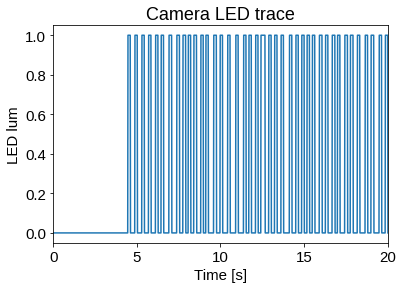

In [32]:
# load the behavior LED and time stamps, IN SECONDS
raw_shifted = timing['time_stamps'][timing['reference_time_cam']]
LED_behavior_raw = raw_shifted[:,-1]
raw_shifted = timing['shifted_stamps'][timing['reference_time_cam']]
LED_behavior = raw_shifted[:,-1]
ts_behavior = timing['reference_stamps'] / 1e3

plt.figure()
plt.plot(ts_behavior,LED_behavior)
plt.xlabel('Time [s]')
plt.ylabel('LED lum')

plt.title('Camera LED trace')
plt.xlim([0,20])
plt.show()


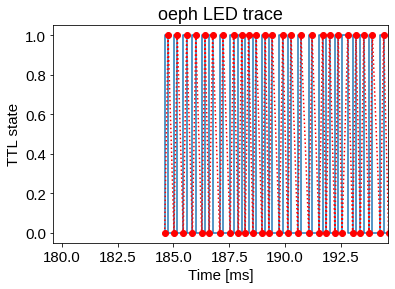

In [33]:
# Rough aligment by simple shift

TTL_sample_rate = 30e3

LED_channel = 7

LED_oeph = TTL_states[TTL_channels == LED_channel]
# open ephys sits high with no LED light, so turn around
LED_oeph = (-LED_oeph /LED_channel + 1.)/2

ts_oeph = TTL_stamps[TTL_channels == LED_channel] / TTL_sample_rate 

plt.figure()
plt.step(ts_oeph,LED_oeph)
plt.plot(ts_oeph,LED_oeph,':or')
plt.xlabel('Time [ms]')
plt.ylabel('TTL state')
plt.title('oeph LED trace')
plt.xlim(ts_oeph[0]+np.array([-5,10]))
plt.show()

In [34]:
# make a function to update the timing with an aligned time!
# LED_oeph,ts_oeph,LED_behavior,ts_behavior, show_plots = True
# align_to_refernces
LED_ref,ts_ref,LED_video,ts_video = LED_oeph,ts_oeph,LED_behavior,ts_behavior
show_plots = True
plt.close('all')

# zero to the first onset (roughly)
# now we find 'big steps' which are big increases!
led_diff = np.diff(LED_video)
big_steps = np.hstack([False, led_diff > .5 ])
# set the first few to false to remove possible noise
big_steps[0:30] = False

bonsai_led_on = ts_video[big_steps]
bonsai_internal_offset = bonsai_led_on[0]
bonsai_led_zeroed = bonsai_led_on-bonsai_internal_offset;

# also find the onset times in the open ephys!
led_diff = np.diff(LED_ref)
# big_steps = np.hstack([False, led_diff > .5 ])
# ref_led_on = ts_ref[big_steps]

# BY DESIGN the TTL flips are 0 when the LED is on
ref_led_on = ts_ref[LED_ref == 0.]

# ~~~~~~~~~~~~
# Process (zero) the open ephys to find first blink of a recording blink (on) times!
# ~~~~~~~~~~~~
# find the LED start of the recordings
# these have extremely long time differences, like above 20x the median for example
big_skips = ref_led_on[ np.hstack( ( False , np.diff(ref_led_on) > 20*np.median(np.diff(ref_led_on)) ) ) ]
first_leds = np.hstack( (ref_led_on[0] , big_skips ) )

# NOW here we zero the open ephys time to the first blink in that recording!
# we zero the open ephys to that first led!
# rec_no = 0+3 # allow fo change the recording to align to
internal_open_offset = first_leds[rec_no];

if len(first_leds > 1):
    # if there are multiple recordings 
    open_led_zeroed = ref_led_on[(ref_led_on >= internal_open_offset)*(ref_led_on < first_leds[rec_no+1])] - internal_open_offset;
else:
    open_led_zeroed = ref_led_on[ref_led_on >= internal_open_offset] - internal_open_offset;

# AND we kill off any open ephys that is outside the recording






In [35]:
# from : http://jonathansoma.com/lede/data-studio/matplotlib/changing-fonts-in-matplotlib/
# Along with matplotlib.pyplot, for this one
# you also need to import matplotlib itself
import matplotlib

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Liberation Sans"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 15})

import matplotlib.font_manager
flist = matplotlib.font_manager.get_fontconfig_fonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


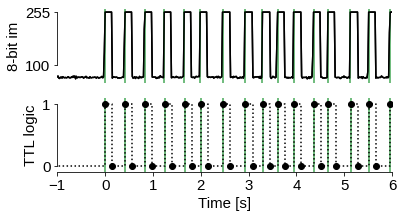

In [36]:
from palettable.cmocean.sequential import Algae_6


if show_plots and False:
#     plt.close('all')
    plt.figure()
    plt.plot(ts_video,LED_video)
    for i in range(100):
        plt.axvline(bonsai_led_on[i],c='r')
    plt.xlim([0,20])
    plt.title('video LED not aligned')
    plt.xlabel('Time [s]')
    plt.show()
    
if show_plots and False:
#     plt.close('all')
    plt.figure()
    plt.plot(ts_ref,LED_ref)
    for i in range(100):
        plt.axvline(ref_led_on[i],c=Algae_6.mpl_colors[1])
    plt.xlim( np.array([0,20]) + ts_ref[0] )
    plt.title('open epehys LED not aligned')
    plt.xlabel('Time [s]')
    plt.show()
    
if show_plots:
#     plt.close('all')
    plt.figure(figsize=(6,3))
    plt.subplot(2,1,1)
#     plt.plot(ts_video-bonsai_internal_offset,LED_video*255)
    
    plt.plot(ts_video-bonsai_internal_offset,LED_behavior_raw,'k')
    
    for i in range(np.min([100,len(bonsai_led_on)])):
        plt.axvline(bonsai_led_on[i]-bonsai_internal_offset,c=Algae_6.mpl_colors[2])
    plt.xlim( np.array([-5,15]) )
#     plt.title('Onset times for alignment')
    plt.ylabel('8-bit im')
#     plt.legend(["raw trace","onset times"])
    ax = plt.gca()
    ax.spines['left'].set_bounds(100,255)

    plt.plot(ts_video-bonsai_internal_offset,LED_behavior_raw,'k')
    plt.xticks([])

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.yticks([100,255])
    ax.spines['left'].set_bounds(100,255)
    
    plt.subplot(2,1,2)
#     plt.plot(ts_ref-internal_open_offset,LED_ref,':o')
    for i in range(100):
        plt.axvline(ref_led_on[i]-internal_open_offset,c=Algae_6.mpl_colors[2],alpha=1.)
    plt.xlim( np.array([-5,15]) )
#     plt.title('open epehys LED zeroed')

    xxx =ts_ref-internal_open_offset
    yyy = LED_ref
    xxx = np.hstack([-10,xxx])
    yyy = np.hstack([.0,yyy])
    plt.step(xxx,yyy,':',color = 'k')
    plt.plot(xxx,1-yyy,'o',color = 'k')

    plt.xlabel('Time [s]')
#     plt.legend(["TTL flips","onset times"])
    plt.ylabel('TTL logic')
    ax = plt.gca()
    ax.set_yticks([0,1])
    plt.ylim([-.1,1.1])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(0,1)
    
    
    for ii in range(2):
        plt.subplot(2,1,1+ii)
        plt.xlim( np.array([-1,6]) )
        sst = 1200.
#         plt.xlim( np.array([-1+sst,6+sst]) )


#     for ii in range(2):
#         plt.subplot(2,1,1+ii)
#         plt.xlim( np.array([-2+1000,8.5+1000]) ) 

#     plt.savefig('figure_raw_pics/figure_1/LED_trace.pdf',bbox_inches = 'tight', pad_inches = 0)
    plt.show()    
    

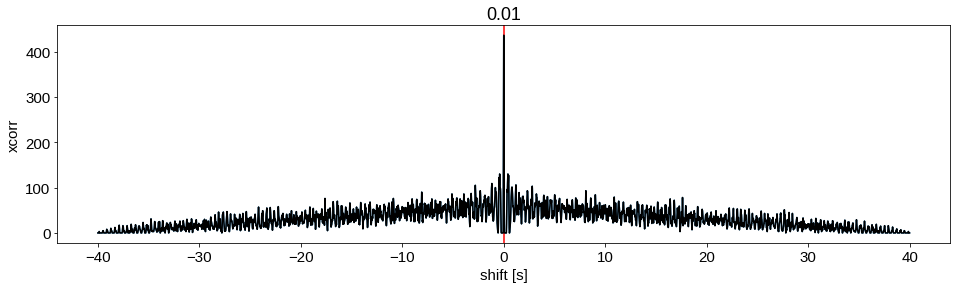

In [37]:
# ~~~~~~~~~~~~
# Use cross correlation to do a finer alignment, we go for 40 s +/- around the first seen blink
# (this is if someone forgets which recording to start first)
# ~~~~~~~~~~~~
# bin the big steps at 10 ms resolution!
test_a = open_led_zeroed
test_b = bonsai_led_zeroed

if show_plots and False:
    plt.figure()
    plt.plot(test_a)
    plt.plot(test_b)
    plt.show()
    
bins = np.arange(0,40,.01) # do 20 s!
# bin the big steps at 20 ms resultions!
count_a, bins_a = np.histogram(test_a,bins=bins)
count_b, bins_b = np.histogram(test_b,bins=bins)

count_a = np.convolve(count_a,np.ones(5),mode='same')
count_b = np.convolve(count_b,np.ones(5),mode='same')

if show_plots and False:
    # show the binned traces
    plt.figure(figsize=(15,5))
    plt.step(bins_a[:-1],count_a)
    plt.step(bins_b[:-1],count_b)
    plt.plot()

from scipy import signal
crosscorr = signal.correlate(count_a, count_b, mode='full',method ='direct')
lags = np.hstack((np.flip(-bins[1:-1]),bins[:-1]))

lag_winner = lags[np.argmax(crosscorr)]
if show_plots:
    # show cross corelellogram
    plt.figure(figsize=(16,4))
    plt.plot(lags,crosscorr)
    plt.axvline(lag_winner,c='r')
    plt.plot(lags,crosscorr,c='k')
    plt.title(lag_winner)
    plt.xlabel('shift [s]')
    plt.ylabel('xcorr')

    plt.show()


In [39]:
# ~~~~~~~~~~~~
# Find the alignement by robust regerssion
# ~~~~~~~~~~~~
# to find the real alignment and 
# Calculate all differences as a big matrix!, only use differences smaller than one second!
# use broadcasting to calculate the big matrix! It will be open_ephys X bonsai
# we align by the lag as well here!
all_differences = open_led_zeroed[:,np.newaxis] - bonsai_led_zeroed - lag_winner;

# find min pr column so min pr bonsai blink
min_location = np.argmin(np.abs(all_differences),0)
# get a list of the smallest distance of the bonsai blinks to an open ephys bit flip
min_diff = all_differences[min_location,np.arange(len(min_location))] 
# only use residuals which are kind of reasonable, like abs residual z<2
abs_diff_small = np.abs(stats.zscore(min_diff)) < 12.;

# fit a robust regression
res = stats.theilslopes(min_diff[abs_diff_small], bonsai_led_on[abs_diff_small], 0.70)
bonsai_offset = res[1];
bonsai_slope = res[0];

# and do the alignment! # remember to add the lag_winner as well!
bonsai_time_aligned = (1+bonsai_slope) * (ts_video - bonsai_internal_offset + lag_winner) + internal_open_offset + bonsai_offset;
# %% For comparison
bonsai_time_rough = (ts_video - bonsai_internal_offset) + internal_open_offset 


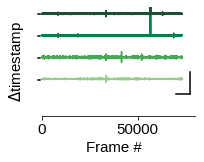

In [42]:
from palettable.colorbrewer.sequential import Blues_8,Greens_5
from palettable.cmocean.sequential import Algae_6

# plt.figure(figsize=(8,2))

plt.figure(figsize=(3,2))


ax = plt.gca()
# ax.set_prop_cycle('color', Greens_5.mpl_colors[1:])
ax.set_prop_cycle('color', Algae_6.mpl_colors[1:])

cam = 2
for cam in range(4):
    stamps=timing['time_stamps'][cam]

    f_idx = stamps[:,0]
    f_n = stamps[:,1]

#     plt.subplot(4,1,1+cam)
#     plt.plot(f_idx[:-1],np.diff(stamps[:,3])*1e3+15*cam,label='unix',c = 'gray')
    plt.plot(f_n[:-1],np.diff(stamps[:,2])+1*cam,label='hw')

    plt.plot([-2000,-1000],np.array([1000/60.,1000/60.])+1*cam,c='k')


    

    
plt.plot(np.array([0.,60*60*2.])+70000,np.array([0,0])+16,c='k')
plt.plot(np.array([60*60*2.,60*60*2.])+70000,np.array([16,17]),c='k')
    
    
#     plt.legend()
#     plt.xlim([2000,200000])
#     plt.xlim([2300,2400])

plt.ylim(15,20)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(0,80000)

# plt.axis('tight')
plt.yticks([])

plt.xlabel('Frame #')
plt.ylabel('$\Delta$timestamp')


# plt.axis('tight')
# plt.savefig('figure_raw_pics/figure_1/frames.pdf', pad_inches = 0.3)

plt.savefig('revision_figures/psth/jitter.pdf',bbox_inches = 'tight', pad_inches = 0)
plt.show()


In [43]:
# calc the median jitter 
dts = []
for cam in range(4):
    stamps=timing['time_stamps'][cam][:,2]
    dts.append(stamps)
    
dts = np.hstack(dts)
print(dts.shape)
diffs = np.diff(dts)
diffs = diffs[diffs>0]
print(diffs[0])
print("jitter: {} ms".format(np.std(diffs)))

(292003,)
16.69775390625
jitter: 0.13826616778270673 ms


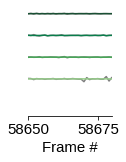

In [44]:
plt.figure(figsize=(1.5,2))
ax = plt.gca()
ax.set_prop_cycle('color', Algae_6.mpl_colors[1:])

cam = 2
for cam in range(4):
    stamps=timing['time_stamps'][cam]

    f_idx = stamps[:,0]
    f_n = stamps[:,1]

#     plt.subplot(4,1,1+cam)
    plt.plot(f_idx[:-1],np.diff(stamps[:,3])*1e3+1*cam,label='unix',c = 'gray')
    plt.plot(f_n[:-1],np.diff(stamps[:,2])+1*cam,label='hw')
#     plt.legend()
#     plt.xlim([2000,200000])
#     plt.xlim([2440,2470])
    plt.xlim([58650,58680])

    
plt.ylim(15,20)
plt.yticks([])

# plt.axis('tight')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('Frame #')
# plt.axis('tight')
# plt.savefig('figure_raw_pics/figure_1/frames_zoom.pdf', pad_inches = 10)

#plt.savefig('figure_raw_pics/figure_1/frames_zoom.pdf',bbox_inches = 'tight', pad_inches = 0)
plt.show()


<Figure size 144x144 with 0 Axes>

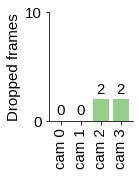

In [45]:
plt.figure(figsize=(2,2))

plt.figure(figsize=(1.5,2))

ax = plt.gca()
ax.set_prop_cycle('color', Algae_6.mpl_colors[1:])

cam = 2

nd = []
pctd = []
for cam in range(4):
    stamps=timing['time_stamps'][cam]

    f_idx = stamps[:,0]
    f_n = stamps[:,1]
    n_unique = np.unique(f_n).shape[0]
    n_all = np.unique(f_n).shape[0]
    n_dropped = n_unique-n_all
    
    all_diffs = np.diff(stamps[:,2])
    n_dropped = np.sum(all_diffs < 10) + np.sum(all_diffs >= 1000/30)
    pct_dropped = n_dropped/np.shape(all_diffs)[0]
    nd.append(n_dropped)
    pctd.append(pct_dropped)

rects1 = plt.bar(np.arange(4),nd)

# for iii in range(4):    
#     plt.bar(iii,nd[iii],color = Algae_6.mpl_colors[iii-4])

    
    
ax = plt.gca()
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['cam 0','cam 1','cam 2','cam 3'],rotation=90.)
ax.set_yticks(np.arange(0,11,2))

# for iii in range(4):    
#     plt.bar(ii,nd[ii])

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

plt.ylabel("Dropped frames")
plt.yticks([0,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_bounds(-.3,3.3)

#plt.savefig('figure_raw_pics/figure_1/dropped_count.pdf',bbox_inches = 'tight', pad_inches = 0)

plt.savefig('revision_figures/psth/dropped.pdf',bbox_inches = 'tight', pad_inches = 0)

plt.show()



In [46]:
# OK, for now, let's just go with the bonsai_time_rough or bonsai_time_aligned!

# During alignment, we had zeroed the ephys time to the first led blink by subtracting internal_open_offset
# this means, that - if we want to do all the anaylsis in the ephys time - we have to add the additional shift to the boinsai time

# REMEMBER THAT THE REFERENCE TIME STAMPS ARE IN MS and the open ephys offset is in seconds!
timing['reference_stamps_ephys_time'] = timing['reference_stamps'] - bonsai_internal_offset * 1e3 + internal_open_offset * 1e3


In [47]:
# Now, load some neurons sorted with phy

spike_index_phy = np.load(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "spike_times.npy")

spike_ids_phy = np.arange(len(spike_index_phy))

clusters_phy = np.load(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "spike_clusters.npy")

templates = np.load(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "templates.npy")

cluster_info = pd.read_csv(ephys_folder+
    "experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+
    "cluster_info.tsv", sep='\t') 

phy_params_path = ephys_folder+"experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous/continuous-merged.GUI/"+                    "params.py"

# also parse the recording start synch time!!!

with open (ephys_folder+
    "experiment1/recording1/sync_messages.txt", "r") as myfile:
    sync_messages=myfile.readlines()


sample_rate = 30000.

# filter only good cells
cluster_info = cluster_info[cluster_info.group == 'good'] #.sort_values(by = 'amp')
cluster_info.head()


,id,amp,ch,depth,fr,group,n_spikes,purity,sh
0,1,88.586761,0,162.5,14.249379,good,53164,0.933629,0.0
4,8,146.340454,18,50.0,0.133477,good,498,0.824229,0.0
6,12,88.986717,24,75.0,21.205748,good,79118,0.909716,0.0
7,13,306.912354,19,100.0,2.061126,good,7690,0.993872,0.0
11,19,91.618080,1,137.5,3.762293,good,14037,0.793313,0.0


In [48]:
sync_messages

['Software time: 4325634@10000000Hz\n',
 'Processor: Rhythm FPGA Id: 100 subProcessor: 0 start time: 4325632@30000Hz\n']

In [49]:
# extract the recording start from the sync_messages by a regular expr
import re
rec_start_sample= int(re.findall(r'[0-9]+@',sync_messages[1])[0][:-1])
print("recording started at sample # {}".format(rec_start_sample))
ephys_rec_start_sample = rec_start_sample
ephys_rec_start_time = rec_start_sample/sample_rate

recording started at sample # 4325632


In [50]:
n_neurons = cluster_info.shape[0]

i_neuron = 10

# let's get it in seconds!
spike_times = spike_index_phy[clusters_phy == cluster_info.id.values[i_neuron]]/sample_rate + ephys_rec_start_time

spike_time_holder = []
for i_neuron in range(n_neurons):
    spike_times = spike_index_phy[clusters_phy == cluster_info.id.values[i_neuron]]/sample_rate + ephys_rec_start_time
    spike_time_holder.append(spike_times)


/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:74: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  matplotlib.rcParams['mathtext.fallback_to_cm'] = False
/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:74: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  matplotlib.rcParams['mathtext.fallback_to_cm'] = False
/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:74: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  matplotlib.rcParams['mathtext.fallback_to_cm'] = False
/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:4357: MatplotlibDeprecationWarning: 
The matht

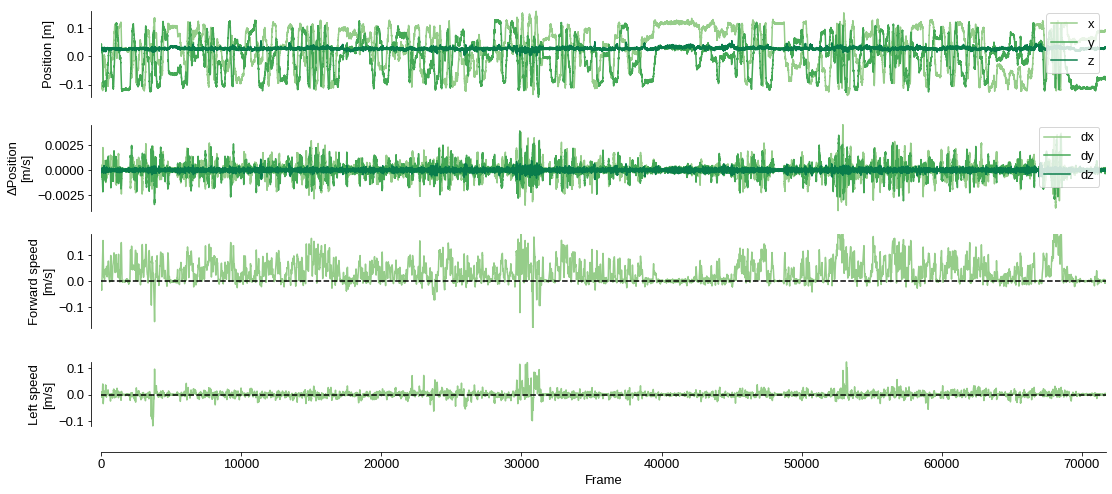

/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/cuda_tracking_utils_weights_for_figures.py:44: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  spine.set_smart_bounds(True)


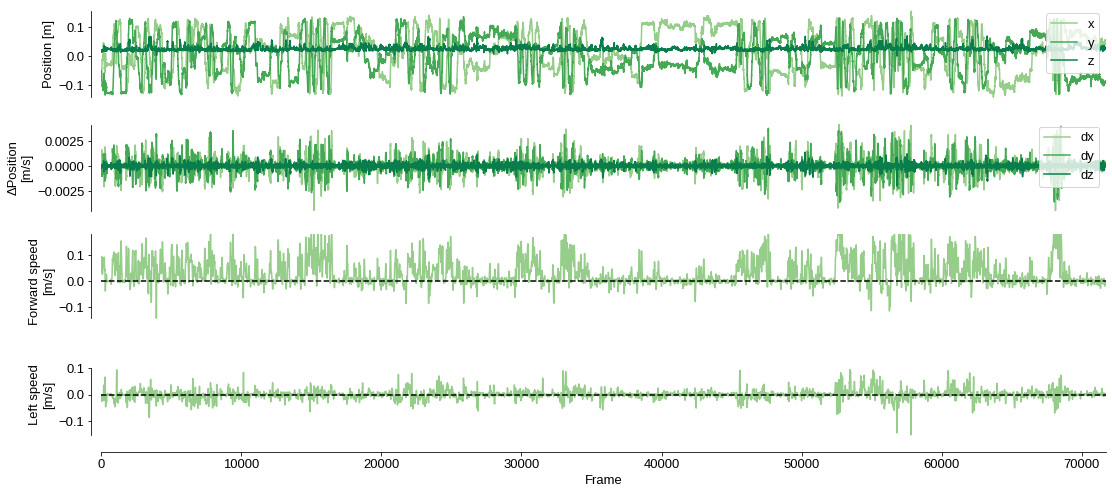

/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:4645: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n_subplots,1,1+i)


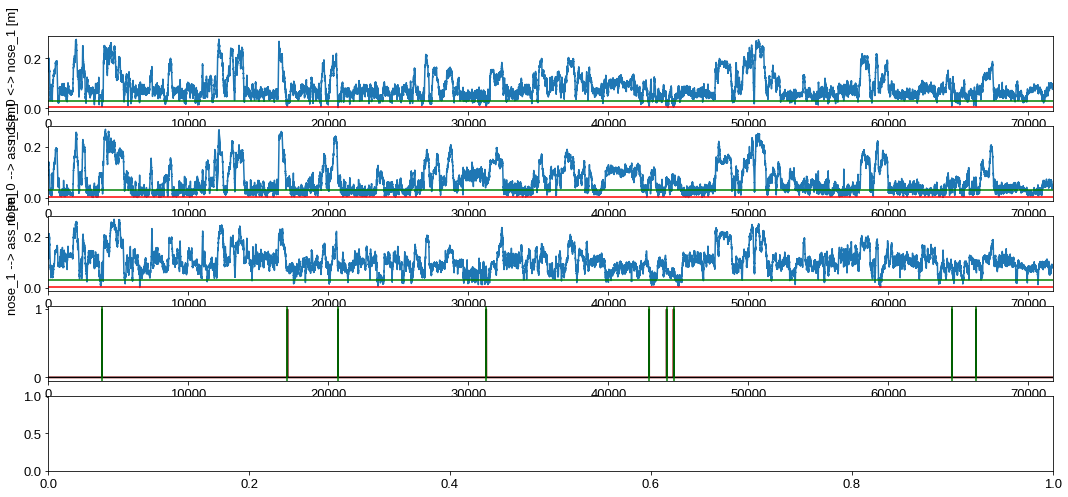

In [51]:
# load some kind of behavior wrangler to discover the relevant time stamps

from utils.analysis_tools import TrackingWrangler
Wrangler = TrackingWrangler(tracked_behavior,jagged_lines)
# Wrangler.kernel_smoothing()
Wrangler.unpack_all_body_support()
Wrangler.unpack_body_points()
Wrangler.calculate_2d_running(zoom = False)
Wrangler.calculate_social_distances(event = 'n2n')

100%|██████████| 71722/71722 [00:44<00:00, 1618.85it/s]


pik


/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:5271: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n_subplots,1,1)


x
y
z


/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:5439: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n_subplots,1,1+subplot_counter)
/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/cuda_tracking_utils_weights_for_figures.py:44: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  spine.set_smart_bounds(True)
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


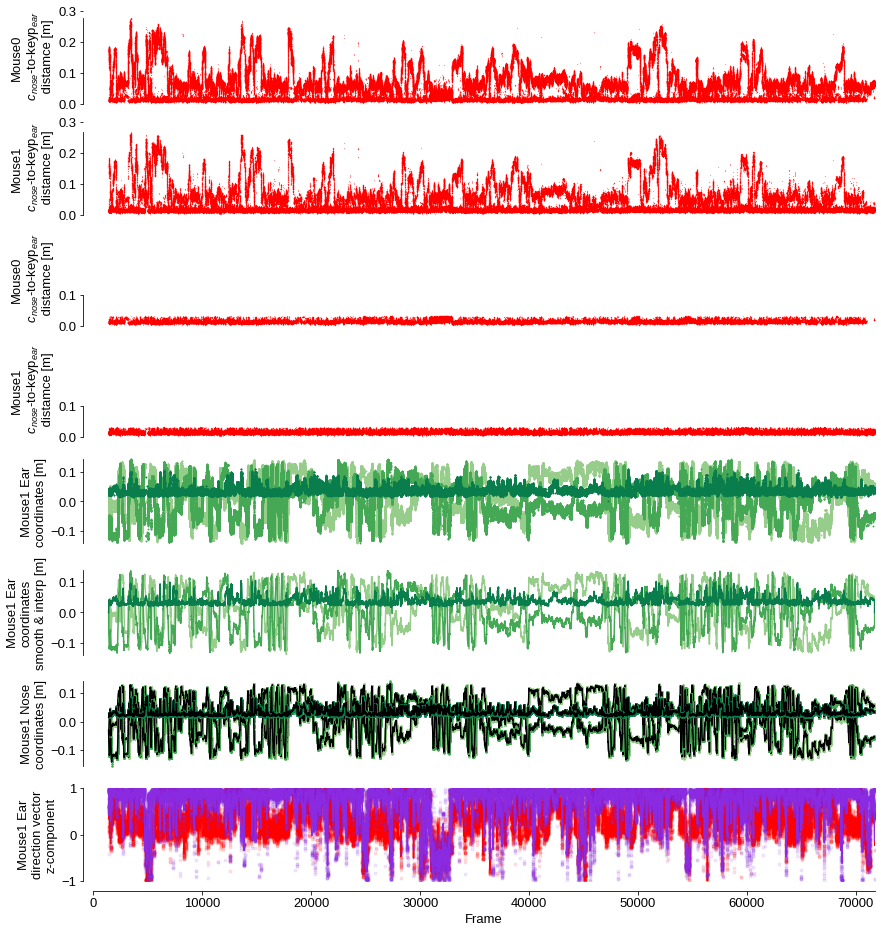

In [52]:
Wrangler.calculate_ear_distance()

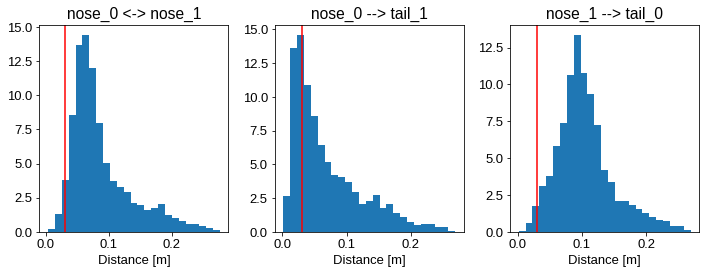

In [53]:
# plot a histogram of the social distances 

self =  Wrangler
labels = ["nose_0 <-> nose_1","nose_0 --> tail_1","nose_1 --> tail_0"]
d_list = [self.d_nose2nose,self.d_nose02ass,self.d_nose12ass]
cutoff = 0.03

plt.figure(figsize = (10,4) )
for i in range(3):
    plt.subplot(1,3,1+i)
    plt.hist(d_list[i],25,density=True)
    plt.title(labels[i])
    plt.xlabel('Distance [m]')
    plt.axvline(cutoff,color='r')
#     plt.xlim([0,.05])
    plt.tight_layout()

plt.savefig('dump_ephys/rob_01/distances_'+partner_sex+'.png',dpi = 200,facecolor='w')

plt.show()


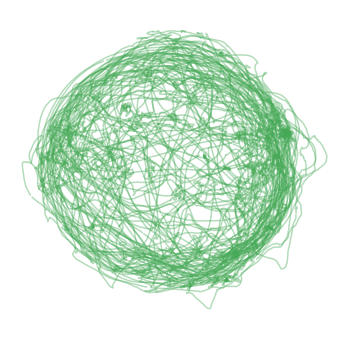

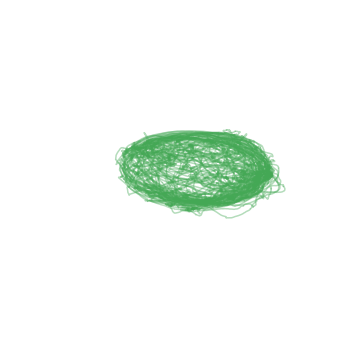

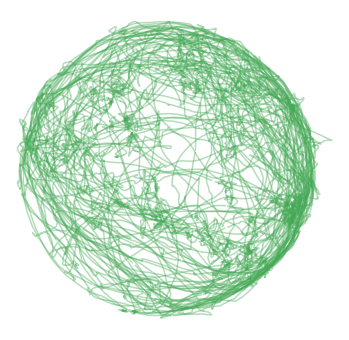

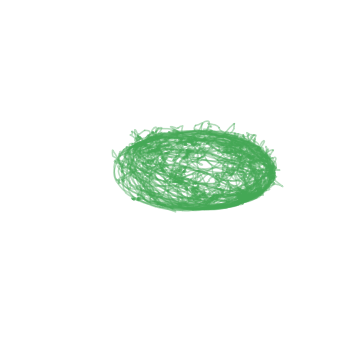

In [54]:
# add all the calculated behavioral features and dump them!
self.plot_spatial_running(body_idx = 0)
self.plot_spatial_running(body_idx = 1)


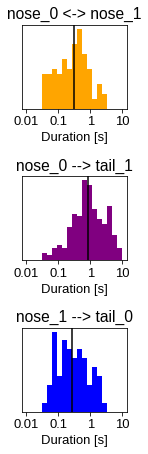

In [55]:
from scipy import ndimage

logic_raw = []
logic_close = []
event_duration = []
event_start = [] 

fps = 60

event_colors = ['orange','purple','blue']

for i in range(3):
    logic_raw.append( d_list[i] < cutoff )
    n_frames_closing = 10
    n_frames_closing = 30
    logic_close.append(ndimage.binary_closing(logic_raw[i],structure = np.ones(n_frames_closing)))
    label_im, nb_labels = ndimage.label(logic_close[i])
    sizes = np.array( [np.sum(label_im == j) for j in range(1,nb_labels+1)] )
    # # frames is where it's true and the previous one is false
    logic_frames = np.argwhere(logic_close[i][:-1]*(~logic_close[i][1:]) ) + 1
    
    # remove events that are only one frame long
    logic_frames = logic_frames[sizes > 1]
    sizes = sizes[sizes > 1]
    
    event_start.append(logic_frames.squeeze())
    event_duration.append(sizes)
    
    
plt.figure(figsize = (2,6.5) )
for i in range(3):
    plt.subplot(3,1,1+i)
    
#     edges = np.linspace( np.log(.01),np.log(10),30)
#     count,_ = np.histogram(np.log(event_duration[i] / fps),bins=edges)
    
#     plt.bar(edges[:-1],count)
    plt.hist(np.log(event_duration[i] / fps),
             bins = np.linspace( np.log(.01),np.log(10),20),density=True,color = event_colors[i])
    plt.title(labels[i])
    plt.xticks(np.log( np.array([.01,.1, 1, 10]) ) )
    ax = plt.gca()
    ax.set_xticklabels([.01,.1, 1, 10] )    
    ax.set_yticks([])
    plt.xlabel('Duration [s]')
    plt.axvline(np.log(np.median(event_duration[i]) / fps),color = 'k')
    plt.tight_layout()

    plt.savefig('revision_figures/psth/durations_'+partner_sex+'.png',dpi = 200,facecolor='w')

plt.show()

In [56]:
# convert the event times to ephys times!

event_times_ephys = []
for i in range(3):
    # the tracked behavior is shifted with respect to reference led stamps:
    event_times_reference = event_start[i] + tracked_behavior['start_frame']
    # the reference stamps are in ms, so divide by 1e3!
    event_times_ephys.append(timing["reference_stamps_ephys_time"][event_times_reference]/1e3)
    


In [57]:
# save the aligned behavior again!
timing['event_times_ephys'] = event_times_ephys
timing['event_duration'] = event_duration
timing['event_start'] = event_start
timing['event_labels'] = labels

tracked_behavior['d_nose2nose'] = self.d_nose2nose
tracked_behavior['d_nose02ass'] = self.d_nose02ass
tracked_behavior['d_nose12ass'] = self.d_nose12ass

tracked_behavior['fwd'] = self.fwd
tracked_behavior['left'] = self.left
tracked_behavior['up'] = self.up

tracked_behavior['body_points'] =self.body_points
tracked_behavior['c_ears_1'] =self.c_ears_1
tracked_behavior['c_ears_smooth_1'] =self.c_ears_smooth_1

# save the aligned data to the ephys folder!

import pickle

# partner_sex = 'female'

pickle.dump( timing,  open( ephys_folder +'timing_'+partner_sex+'.pkl', "wb" ) )
pickle.dump( tracked_behavior, open( ephys_folder+'tracked_behavior_'+partner_sex+'.pkl', "wb" ) )




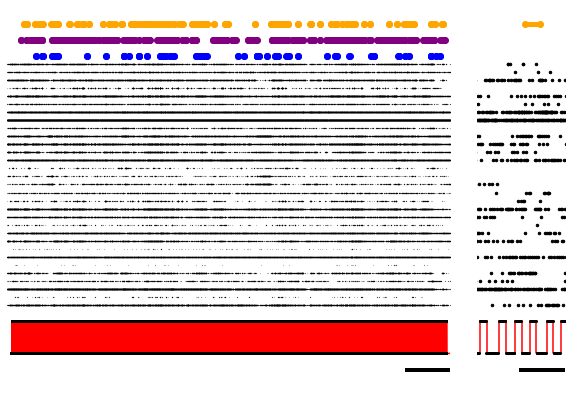

In [80]:
# SYnchronization 
# make a kind of cheap ethogram
import matplotlib.gridspec as gridspec


zoom = False
if zoom:
    plt.figure(figsize =(2,7))
else:
    plt.figure(figsize =(10,7))

    buff = 10

gs = gridspec.GridSpec(1, 2,width_ratios=[5,1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])    
    
for i_sub,ax in enumerate([ax1,ax2]):

    if i_sub == 0:
        mz = .2
    else:
        mz = 5
    
    for ii in range(31):
        spike_times = spike_time_holder[ii]
        ax.plot(spike_times,ii*np.ones_like(spike_times)/2,'.k',markersize = mz,label = 'spikes from random cluster')

    for i_event,event_color in enumerate(event_colors):
        # start and end times!
        es = (event_times_ephys[i_event])
        ee = (event_times_ephys[i_event]+event_duration[i_event]/60)
        for s,e in zip(es,ee):
            ax.plot([s,e],n_neurons/2*np.ones(2)+2-i_event,'-o',c=event_color,lw=5)

        #     plt.plot(,2.33*np.ones_like(event_times_ephys[i_event])-.33*(i_event+1),'.',c=event_color,label=labels[i_event])



    ax.step(ts_oeph,-3+2*LED_oeph,'r',label = 'ephys LED stamps')
    ref_stamps = timing['reference_stamps_ephys_time']/1e3
    ax.plot(ref_stamps,-3+2*LED_behavior,'.k',markersize=4,label='video LED stamps\nfor this video')

    # plt.xlim(np.array([200, 210]) +  timing['reference_stamps_ephys_time'][0]/1e3   )



#     ax.xlabel('time [s]')
    # plt.legend(bbox_to_anchor=(0, 1), loc='upper right', ncol=1)
    # plt.ylim([-.5,2.5])
    buff = 10
    ax.set_xlim([ref_stamps[0]-buff,ref_stamps[-1]+buff])


    mm = np.median(ref_stamps)


    if i_sub == 1:
        buff = 1
        mm = 400-.5
        ax.set_xlim([mm-buff,mm+buff])
        
        ax.plot([mm+buff-1,mm+buff],-4*np.ones(2),'k',lw=4)
    else:
        ax.plot([ref_stamps[-1]+buff-120,ref_stamps[-1]+buff],-4*np.ones(2),'k',lw=4)


    # plt.title('Synchronization check')
    # plt.tight_layout()

    ax.axis('off')
plt.subplots_adjust(wspace=0.1)
    
if zoom:
    plt.savefig('revision_figures/psth/synczoom_'+partner_sex+'.png',dpi = 200,transparent=True)
else:
    plt.savefig('revision_figures/psth/sync_'+partner_sex+'.png',dpi = 200,transparent=True)

plt.show()

In [165]:
# Make a function that plots a psth onto an axis
def ax_paint_raster(ax,spike_times, event_times, pre_time = 4, post_time =2, dotcolor = 'k', linecolor = 'peru'):

        aligned_spikes = []
        for i,et in enumerate(event_times):
            st = spike_times[( spike_times >= (et-pre_time) )*( spike_times < (et+post_time) ) ] - et
            aligned_spikes.append(st)
            
            ax.plot(st,np.ones_like(st) + i,'.',markersize = .5,color=dotcolor)

        ax.set_xlim([-pre_time,post_time])
        ax.set_ylim([0-1,i+1])
        ax.axvline(0,c = linecolor)     


In [166]:
def ax_paint_psth(ax,spike_times, event_times, pre_time = 4, post_time =2, facecolor = 'lightgray', linecolor = 'peru'):

        aligned_spikes = []
        for i,et in enumerate(event_times):
            st = spike_times[( spike_times >= (et-pre_time) )*( spike_times < (et+post_time) ) ] - et
            aligned_spikes.append(st)
        
        # bin the counts
        edges = np.linspace(-pre_time,post_time,40)
        count,_ = np.histogram(np.hstack(aligned_spikes),edges )

        rate = count/len(event_times) / np.median(np.diff(edges))
        
        ax.bar(edges[:-1],rate,width = np.median(np.diff(edges)), align ='edge' ,facecolor=facecolor)
        ax.set_xlim([-pre_time,post_time])    
        ax.axvline(0,c = linecolor) 
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Firing rate [Hz]')
        

In [167]:
def ax_paint_common_yaxis(axs):
    current_max = [ax.get_ylim()[1] for ax in axs]
    max_all = np.max(current_max)
    for ax in axs:
        ax.set_ylim(top = max_all)

In [830]:
# using phy's fast acorr loop"
from phylib.stats import correlograms, firing_rate
def ax_paint_acorr(ax,spike_times,facecolor = 'grey'):
    window_size = 0.05
    bin_size = 0.001
    acorr = correlograms(spike_times,np.zeros_like(spike_times,dtype='int'),cluster_ids=[0],bin_size = bin_size,
                         window_size=window_size,sample_rate = 30000.)
    n_bins = len(acorr.squeeze())
    # acorr_times = np.arange(-window_size,window_size,bin_size)
    ax.bar( np.arange(0,n_bins), acorr.squeeze(),width = 1 ,facecolor = facecolor)
    ax.set_yticks([])
    ax.set_xlabel("Time [ms]")
    ax.set_xticks([0,window_size/bin_size])
    ax.set_xticklabels([-window_size*1e3,window_size*1e3])
    ax.set_ylabel('acorr')
    

    

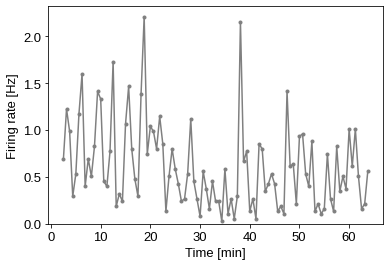

In [831]:
def ax_paint_firing_rate(ax,spike_times,rec_start = None,rec_end= None,n_bins = 60,linecolor = 'grey'):
    
    if rec_end is None:
        rec_end = spike_times.max()
    if rec_start is None:
        rec_start = spike_times.min()
        
    edges = np.linspace(rec_start,rec_end,n_bins)
    binned_spikes,_ = np.histogram(spike_times,edges)
    
    rate = binned_spikes/np.median(np.diff(edges))
    
    ax.plot(edges[:-1]/60,rate,'.-',c = linecolor)
#     ax.set_yticks([])
    ax.set_xlabel("Time [min]")
    ax.set_ylim([0,None])
#     ax.set_xticks([0,window_size/bin_size])
#     ax.set_xticklabels([-window_size*1e3,window_size*1e3])
    ax.set_ylabel('Firing rate [Hz]')
plt.figure()
ax = plt.gca()
ax_paint_firing_rate(ax,spike_times,rec_end= None,n_bins = 100,linecolor = 'grey')
plt.show()

In [156]:
cluster_id = 12

def ax_paint_templates(ax,cluster_id,phy_params_path,linecolor= 'peru'):
    # load the spike templates using the phy interface
    from phylib.io.model import load_model

    # Load the TemplateModel instance.
    model = load_model(phy_params_path)

    # Load a given template.
    bunch = model.get_template(cluster_id)

    # get out the channel_ids and waves
    wave_channels = bunch.channel_ids
    waveforms = bunch.template

    # load the probe
    spyking_circus_path = '/media/chrelli/SSD4TB/EPHYS_COPY/Cambridge_P2_circus_cleaner.prb'
    probe = {}
    with open(spyking_circus_path, 'r') as f:
        probetext = f.read()
        exec(probetext, probe)
        del probe['__builtins__']

    # plot the probe locations
    for ii in range(32):
        probe_xy = probe['channel_groups'][0]['geometry'][ii]

        # shift the shanks closer together
        if probe_xy[0] > 200:
            probe_xy[0] -= 150 

        ax.plot(probe_xy[0],probe_xy[1],'o',color = 'gray')

    # plot the waveforms    
    for i_ch,ch in enumerate(wave_channels):
        wave = waveforms[:,i_ch]
        probe_xy = probe['channel_groups'][0]['geometry'][ch]


        wave_width = 20
        wave_scaling = 0.3
        wave_x = np.linspace(0,1,len(wave)) * wave_width
#         ax.plot(wave_x + probe_xy[0], wave_scaling*wave + probe_xy[1],color = linecolor)
        ax.plot(wave_x + probe_xy[0], wave_scaling*wave + probe_xy[1])
    
    ax.set_ylim(-15,187.5+15)    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

In [157]:
# copied from phylab, because they keep it hidden

def _extract_waveform(traces, sample, channel_ids=None, n_samples_waveforms=None):
    """Extract a single spike waveform."""
    nsw = n_samples_waveforms
    assert traces.ndim == 2
    dur = traces.shape[0]
    a = nsw // 2
    b = nsw - a
    assert nsw > 0
    assert a + b == nsw
    if channel_ids is None:  # pragma: no cover
        channel_ids = slice(None, None, None)
        n_channels = traces.shape[1]
    else:
        n_channels = len(channel_ids)
    t0, t1 = int(sample - a), int(sample + b)
    # Extract the waveforms.
    w = traces[max(0, t0):t1][:, channel_ids]
    if not isinstance(channel_ids, slice):
        w[:, channel_ids == -1] = 0
    # Deal with side effects.
    if t0 < 0:
        w = np.vstack((np.zeros((nsw - w.shape[0], n_channels), dtype=w.dtype), w))
    if t1 > dur:
        w = np.vstack((w, np.zeros((nsw - w.shape[0], n_channels), dtype=w.dtype)))
    assert w.shape == (nsw, n_channels)
    return w

def extract_waveforms(traces, spike_samples, channel_ids, n_samples_waveforms=None):
    """Extract waveforms for a given set of spikes, on certain channels."""
    # Create the output array.
    ns = len(spike_samples)
    nsw = n_samples_waveforms
    assert nsw > 0, "Please specify n_samples_waveforms > 0"
    nc = len(channel_ids)
    # Extract the spike waveforms.
    out = np.zeros((ns, nsw, nc), dtype=traces.dtype)
    for i, ts in enumerate(spike_samples):
        out[i] = _extract_waveform(
            traces, ts, channel_ids=channel_ids, n_samples_waveforms=nsw)[np.newaxis, ...]
    return out




In [158]:
cluster_id = 12

def ax_paint_waves(ax,cluster_id,phy_params_path,linecolor= 'peru',dotcolor ='peru',all_channels = False):
    # load the spike templates using the phy interface
    from phylib.io.model import load_model

    # Load the TemplateModel instance.
    model = load_model(phy_params_path)

    # get out the channel_ids and waves
    if all_channels:
        wave_channels = np.arange(32)
    else:
        wave_channels = bunch.channel_ids

    n_samples_waveforms = 100
    n_waveforms = 100
    model.n_samples_waveforms = n_samples_waveforms
    samples_to_load = np.random.choice(spike_index_phy[clusters_phy == cluster_id],size=n_waveforms,replace=False)
    waveforms = extract_waveforms(model.traces,samples_to_load,wave_channels,n_samples_waveforms)

    # load the probe
    spyking_circus_path = '/media/chrelli/SSD4TB/EPHYS_COPY/Cambridge_P2_circus_cleaner.prb'
    probe = {}
    with open(spyking_circus_path, 'r') as f:
        probetext = f.read()
        exec(probetext, probe)
        del probe['__builtins__']

    # plot the probe locations
    for ii in range(32):
        probe_xy = probe['channel_groups'][0]['geometry'][ii]

        # shift the shanks closer together
        if probe_xy[0] > 200:
            probe_xy[0] -= 180 

        ax.plot(probe_xy[0],probe_xy[1],'o',color = dotcolor)

    # plot the waveforms    
    for i_ch,ch in enumerate(wave_channels):
        waves = waveforms[:,:,i_ch]

        probe_xy = probe['channel_groups'][0]['geometry'][ch]

        wave_width = 20
        wave_scaling = 0.01        
        wave_x = np.linspace(0,1,waves.shape[1]) * wave_width
        
        for j_wave in range(n_samples_waveforms):
            
    #         ax.plot(wave_x + probe_xy[0], wave_scaling*wave + probe_xy[1],color = linecolor)
            ax.plot(wave_x + probe_xy[0], wave_scaling*waves[j_wave,:] + probe_xy[1], c = linecolor, alpha = max(1/n_waveforms,0.01))
        
    ax.set_ylim(-15,187.5+15)    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
# plt.figure()
# ax = plt.gca()
# ax_paint_waves(ax,cluster_id,phy_params_path,linecolor= 'k',all_channels = True)
# plt.show()